In [50]:
import pandas as pd

In [51]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [52]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

cat = ['Sex', 'ChestPainType', 'RestingECG', 'ST_Slope', 'ExerciseAngina']

preprocessor = ColumnTransformer(transformers =[
    ('col', OneHotEncoder(sparse_output = False), cat)
],
    remainder = 'passthrough')

pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100,
                               criterion = 'gini',
                               max_depth = 15,
                               max_features = 'sqrt',
                               class_weight = 'balanced',
                               min_samples_leaf = 5,
                               min_samples_split = 10,
                               random_state=42))
])
X = df.drop('HeartDisease', axis = 1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

pipeline.fit(X_train,y_train)

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

y_pred = pipeline.predict(X_test)
y_pred_t = pipeline.predict(X_train)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
print("Test Accuarcy :", accuracy_score(y_test, y_pred))
print("Train Accuarcy :", accuracy_score(y_train, y_pred_t))
print('Roc Auc :', roc_auc_score(y_test,y_pred_proba))
print(confusion_matrix(y_test,y_pred))

Test Accuarcy : 0.8695652173913043
Train Accuarcy : 0.9073569482288828
Roc Auc : 0.9416191285350165
[[66 11]
 [13 94]]


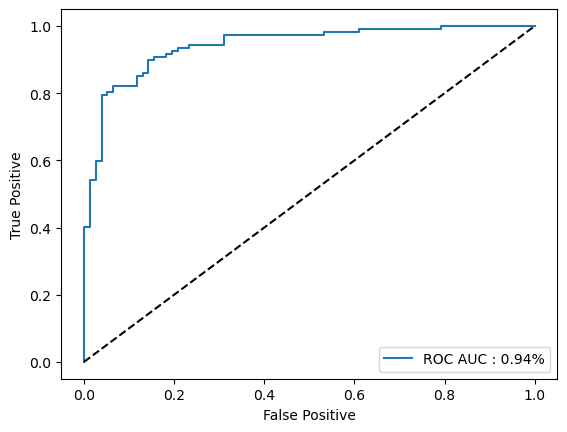

In [60]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

roc = roc_auc_score(y_test,y_pred_proba)
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label = f"ROC AUC : {roc:.2f}%")
plt.plot([0,1],[0, 1], 'k--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()

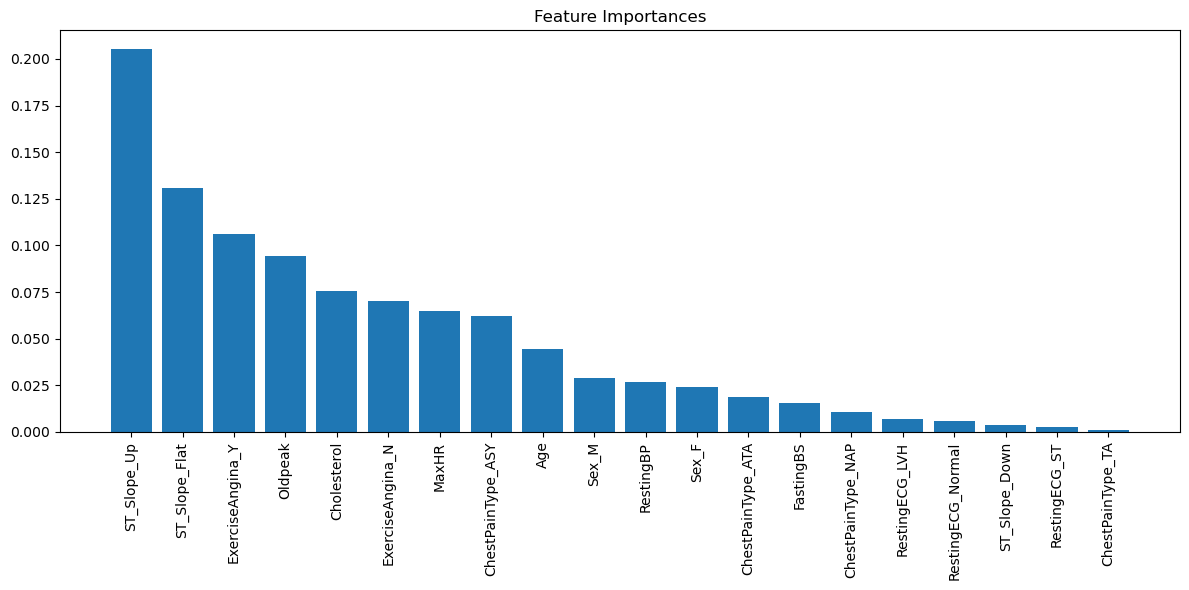

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get the trained RandomForest model from the pipeline
model = pipeline.named_steps['model']

# Step 2: Get feature names from OneHotEncoder
# Categorical feature names (after one-hot)
ohe = pipeline.named_steps['preprocess'].named_transformers_['col']
ohe_feature_names = ohe.get_feature_names_out(cat)

# Step 3: Get final feature names (categorical + numerical)
# Since you used remainder='passthrough', numerical features are passed as-is
num_features = [col for col in df.columns if col not in cat + ['HeartDisease']]
all_features = np.concatenate([ohe_feature_names, num_features])

# Step 4: Get feature importances and sort
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort descending

# Step 5: Plot
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), all_features[indices], rotation=90)
plt.tight_layout()
plt.show()
